In [19]:
# General
import os
from os.path import join
import logging
import random

# Data wrangling
import pandas as pd
import numpy as np

# Prediction
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, DMatrix, train
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix

# Hyperparameter Optimisation
import optuna

# Visualisation
import matplotlib.pyplot as plt

In [20]:
class Dataset:
    """
    Class representing a dataset
    """
    def __init__(self, df):
        """
        Initialiser method (constructor) of dataset object. Takes parameters:

        (1) df - dataframe holding data
        """
        self.df = df
    def combine_features(self, row, col1, col2):
        """
        Feature combining method which unpacks large feature vectors into features such that every dimension
        has its own feature

        (1) row - row of dataframe
        (2) col1 - column of dataframe containing first vector to be unpacked
        (3) col2 - column fo dataframe containing second vector to be unpacked
        """
        return np.concatenate([row[col1], row[col2]])
    def train_test(self, enzyme_rep, substrate_rep, train_size):
        """
        Train test split method which creates a train test split of the dataset
        ensuring that no enzyme is split across training and testing. Takes parameters:

        (1) train_size - percentage of dataset going to training
        """
        self.enzyme_rep = enzyme_rep
        self.substrate_rep = substrate_rep
        self.train_size = train_size
        train_enzymes = np.random.choice(self.df['enzyme'].unique(), size=int(len(self.df['enzyme'].unique()) * self.train_size), replace=False)
        train_df = self.df[self.df['enzyme'].isin(train_enzymes)].copy()
        test_df = self.df[~self.df['enzyme'].isin(train_enzymes)].copy()
        train_df.loc[:, (enzyme_rep + '_' + substrate_rep + '_Combined')] = train_df.apply(self.combine_features, args = (enzyme_rep, substrate_rep), axis=1)
        test_df.loc[:, (enzyme_rep + '_' + substrate_rep + '_Combined')] = test_df.apply(self.combine_features, args = (enzyme_rep, substrate_rep), axis=1)
        X_train = np.stack(train_df[enzyme_rep + '_' + substrate_rep + '_Combined'].values)
        X_test = np.stack(test_df[enzyme_rep + '_' + substrate_rep + '_Combined'].values)
        y_train = train_df['active']
        y_test = test_df['active']
        return X_train, y_train, X_test, y_test

In [21]:
class Model:
    """
    Class representing a machine learning model
    """
    def __init__(self, X_train, y_train, X_test, y_test):
        """
        Initialiser method (constructor) of dataset object. Takes parameters:

        (1) X_train - training features
        (2) y_train - training labels
        (3) X_test - testing features
        (4) y_test - testing labels
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None

    def tune_hyperparameters(self, n_trials=50):
        """
        Hyperparameter tuning method using Optuna
        """
        def objective(trial):
            param = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            }
            
            model = XGBClassifier(**param)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            accuracy = roc_auc_score(self.y_test, y_pred)
            return accuracy
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        print(f"Best hyperparameters: {study.best_params}")
        self.best_params = study.best_params

    def evaluate(self, choice='xgb', tune=False, n_trials=50):
        """
        Model evaluation method - outputs accuracy, area under ROC curve, and ROC curve
        """
        self.choice = choice
        
        if choice == 'xgb':
            if tune:
                self.tune_hyperparameters(n_trials=n_trials)
                self.model = XGBClassifier(**self.best_params)
            else:
                self.model = XGBClassifier()
            
            self.model.fit(self.X_train, self.y_train)
        
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        area_under_roc = roc_auc_score(self.y_test, y_pred)
        confuse = confusion_matrix(self.y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(f"Area Under ROC Curve: {area_under_roc}")
        print('Confusion Matrix:\n', confuse)
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred, pos_label=1)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color="darkorange", lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc_score(self.y_test, y_pred),
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        plt.show()

In [22]:
CURRENT_DIR = os.getcwd()
balanced_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'balanced_df.pkl'))
enzyme_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'enzyme_df.pkl'))

In [23]:
data = Dataset(balanced_df)

[I 2024-07-01 12:13:58,301] A new study created in memory with name: no-name-e7c8be4e-e205-4595-bad9-24e60369e6aa
[I 2024-07-01 12:15:21,083] Trial 0 finished with value: 0.76645419452029 and parameters: {'max_depth': 9, 'learning_rate': 0.08946048012223563, 'n_estimators': 480, 'gamma': 3.3527540473016653, 'min_child_weight': 4, 'subsample': 0.5528444380554017, 'colsample_bytree': 0.5960389349206986, 'reg_alpha': 0.7099385736356508, 'reg_lambda': 0.260406153355231}. Best is trial 0 with value: 0.76645419452029.
[I 2024-07-01 12:16:40,516] Trial 1 finished with value: 0.760479631547563 and parameters: {'max_depth': 8, 'learning_rate': 0.1946949460321866, 'n_estimators': 920, 'gamma': 4.7500581709043646, 'min_child_weight': 1, 'subsample': 0.7053890411952679, 'colsample_bytree': 0.88224758016146, 'reg_alpha': 0.3569397098641839, 'reg_lambda': 0.9104017764121941}. Best is trial 0 with value: 0.76645419452029.
[I 2024-07-01 12:20:30,188] Trial 2 finished with value: 0.7769324922323699 and

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.12712493103189165, 'n_estimators': 758, 'gamma': 0.6095827131748299, 'min_child_weight': 3, 'subsample': 0.8318069897155145, 'colsample_bytree': 0.9964373094416407, 'reg_alpha': 0.8197404536252814, 'reg_lambda': 0.10781697988602135}
Accuracy: 0.8850588663672776
Area Under ROC Curve: 0.7851059614600007
Confusion Matrix:
 [[6085   90]
 [ 857 1207]]


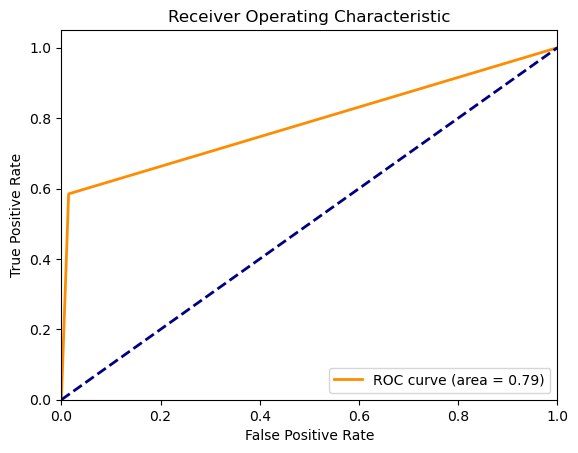

In [24]:
X_train_esm1b, y_train_esm1b, X_test_esm1b, y_test_esm1b = data.train_test('ESM1b', 'fingerprint', 0.8)
model = Model(X_train_esm1b, y_train_esm1b, X_test_esm1b, y_test_esm1b)
model.evaluate(choice = 'xgb', tune = True, n_trials = 10)

Accuracy: 0.8717615047911984
Area Under ROC Curve: 0.7615413194529843
Confusion Matrix:
 [[6224  111]
 [ 973 1145]]


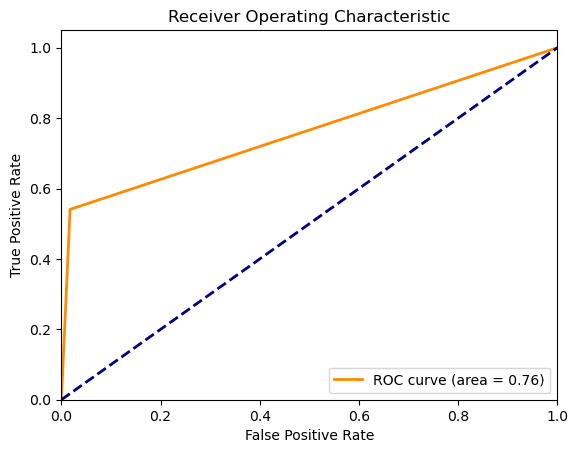

In [25]:
X_train_esm2, y_train_esm2, X_test_esm2, y_test_esm2 = data.train_test('ESM2', 'fingerprint', 0.8)
model = Model(X_train_esm2, y_train_esm2, X_test_esm2, y_test_esm2)
model.evaluate('xgb')

In [26]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

NameError: name 'hp' is not defined

In [ ]:
def objective(space):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
def cross_validation_neg_acc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'binary:logistic'
    weights = np.array([param["weight"] if activity == 0 else 1.0 for activity in unique_df["active"]])
    
    del param["num_rounds"]
    del param["weight"]
    dtrain = DMatrix(np.array(X_train), weight = weights,
                        label = np.array(y_train))
    dvalid = DMatrix(np.array(X_test))
    bst = train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = y_test

    false_positive = 100*(1-np.mean(np.array(validation_y)[y_valid_pred == 1]))
    false_negative = 100*(np.mean(np.array(validation_y)[y_valid_pred == 0]))
    logging.info("False positive rate: " + str(false_positive)+ "; False negative rate: " + str(false_negative))
    loss = 2*(false_negative**2) + false_positive**1.3
    return loss

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [9,10,11,12,13]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400),
    "weight" : hp.uniform("weight", 0.1,0.33)}

In [ ]:
trials = Trials()

for i in range(1,2000):
    best = fmin(fn = cross_validation_neg_acc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = i, trials = trials)
    logging.info(i)
    logging.info(trials.best_trial["result"]["loss"])
    logging.info(trials.argmin)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

job exception: name 'unique_df' is not defined



  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]


NameError: name 'unique_df' is not defined

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.5806451612903226                                     
SCORE:                                                                            
0.5806451612903226                                                                
SCORE:                                                                            
0.5806451612903226                                                                
SCORE:                                                                            
0.5806451612903226                                                                
SCORE:                                                                            
0.5806451612903226                                                                
SCORE:                                                                            
0.5806451612903226                                                                
SCORE:                                                    

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9791752788867817, 'gamma': 1.2350839923267003, 'max_depth': 9.0, 'min_child_weight': 6.0, 'reg_alpha': 95.0, 'reg_lambda': 0.45052028176562187}


In [ ]:
param = {'colsample_bytree': 0.9791752788867817, 'gamma': 1.2350839923267003, 'max_depth': 9.0, 'min_child_weight': 6.0, 'reg_alpha': 95.0, 'reg_lambda': 0.45052028176562187}

model = XGBClassifier(
    colsample_bytree = 0.9791752788867817,
    gamma = 1.2350839923267003,
    max_depth = 9,
    min_child_weight = 6,
    reg_alpha = 95,
    reg_lambda = 0.45052028176562187
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9791752788867817, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2350839923267003,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.5806451612903226
Area Under ROC Curve: 0.5
Confusion Matrix:
 [[144   0]
 [104   0]]


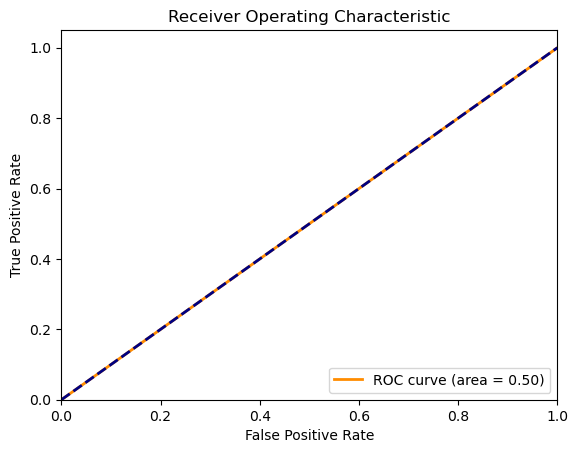

In [ ]:
evaluate(X_test, y_test)